# 1. Librerías Necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from wordcloud import WordCloud, ImageColorGenerator
from scipy.misc import imread
from nltk.corpus import stopwords as sw

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from analytics import *

# 2. Leer datos de texto 

In [2]:
opiniones=pd.read_excel('Datos/mltext.xlsx',sheetname='AME')
opiniones.head()

,estrellas,opinion
0,1,No me gusta
1,2,"No me gusta el futbol, además dicen que este e..."
2,5,Es un equipo de los considerados grandes de Me...
3,5,QUE CHINGUE A SU MADRE EL AMERICA
4,5,QUE CHINGUE A SU MADRE EL AMERICA


In [3]:
proc_freq(opiniones,'estrellas',False)

Frequency distribution table for variable: estrellas


   Freq       Pct  Accum Freq  Accum Pct
0     4  0.007576         528   1.000000
1   325  0.615530         325   0.615530
2    56  0.106061         455   0.861742
3    74  0.140152         399   0.755682
4    26  0.049242         524   0.992424
5    43  0.081439         498   0.943182




In [4]:
#1 indica positivo, 2 indica negativo
opiniones['sentimiento']=np.where(opiniones.estrellas>3,1,0)

In [5]:
proc_freq(opiniones,['sentimiento','estrellas'],False)

Frequency distribution table for variable: sentimiento


   Freq       Pct  Accum Freq  Accum Pct
0   459  0.869318         459   0.869318
1    69  0.130682         528   1.000000


Frequency distribution table for variable: estrellas


   Freq       Pct  Accum Freq  Accum Pct
0     4  0.007576         528   1.000000
1   325  0.615530         325   0.615530
2    56  0.106061         455   0.861742
3    74  0.140152         399   0.755682
4    26  0.049242         524   0.992424
5    43  0.081439         498   0.943182




# 3. Preparar Datos para scikit-learn

In [7]:
X=opiniones.opinion
y=opiniones.sentimiento
Xt,Xv,yt,yv=train_test_split(X,y,train_size=0.8)
print Xt.shape
print Xv.shape
print yt.shape
print yv.shape

(422L,)
(106L,)
(422L,)
(106L,)


# 4. Exploración mediante nube de palabras

In [8]:
texto=Xt.to_string(index=False).lower()
texto=texto.split()
#diccionario de palabras de escape, palabras muy comunes o con trascendencia gramatical solamente
stopwords=sw.words('spanish')
#stopwords.extend(['dan','creo','coordinacion'])
texto=[pal for pal in texto if pal not in stopwords]
texto=" ".join(texto)
#print texto

**Nube cuadrada**

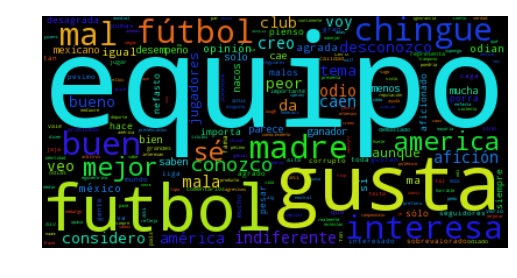

In [9]:
wordcloud = WordCloud().generate(texto)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Nube anclada a una imagen**

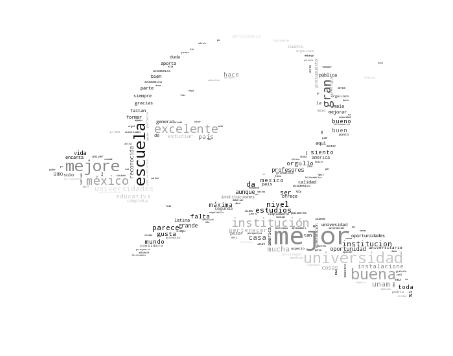

In [28]:
%matplotlib inline
imagen_act=imread('images/mask_actuaria_acatlan.png')
colores_imagen = ImageColorGenerator(imagen_act)

wordcloud = WordCloud(mask=imagen_act,
                      max_font_size=40,
                      background_color='white',
                     ).generate(texto)

#plt.imshow(imagen_act)
plt.imshow(wordcloud)
plt.imshow(wordcloud.recolor(color_func=colores_imagen))

plt.axis("off")
plt.show()

# 4. Vectorizar texto

In [10]:
cvect=CountVectorizer(encoding='utf8',
                      stop_words=stopwords,
                      strip_accents='unicode',
                      ngram_range=(1,4))
cvect.fit(Xt)
dtmt=cvect.transform(Xt)
dtmv=cvect.transform(Xv)
#pal_df=pd.DataFrame(dtm.toarray(),columns=cvect.get_feature_names())
#proc_freq(pal_df,pal_df.columns.tolist(),False)

# 6. Clasificadores predictivos

In [11]:
mnb=MultinomialNB()
mnb.fit(dtmt,yt)
logreg=LogisticRegression()
logreg.fit(dtmt,yt)
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(dtmt,yt)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [12]:
plot_roc_curve([(mnb,'Multinomial Naive-Bayes'),
                (logreg,'Regresion Logistica'),
                (knn,'KNN')],dtmv,yv)

In [13]:
negativos=mnb.feature_count_[0,:]
positivos=mnb.feature_count_[1,:]
tokens=cvect.get_feature_names()
tokens=pd.DataFrame({'token':tokens,'positivos':positivos,'negativos':negativos}).set_index('token')
tokens.head()

,negativos,positivos
token,,
absoluto,1.0,0.0
absurdo,1.0,0.0
absurdo nefastos,1.0,0.0
absurdo nefastos aficionados,1.0,0.0
aburrido,1.0,0.0


In [14]:
tokens['positivos'] = tokens.positivos + 1
tokens['negativos'] = tokens.negativos + 1
tokens['positivos'] = tokens.positivos / mnb.class_count_[1]
tokens['negativos'] = tokens.negativos / mnb.class_count_[0]
tokens['ratio_positivo'] = tokens.positivos / tokens.negativos
tokens['ratio_negativo'] = tokens.negativos / tokens.positivos
tokens.sort_values('ratio_negativo', ascending=False,inplace=True)
tokens.head(20)

,negativos,positivos,ratio_positivo,ratio_negativo
token,,,,
mal,0.070461,0.018868,0.267779,3.734417
gusta futbol,0.075881,0.037736,0.497305,2.010840
madre,0.097561,0.056604,0.580189,1.723577
chingue,0.094851,0.056604,0.596765,1.675700
creo,0.029810,0.018868,0.632933,1.579946
odio,0.029810,0.018868,0.632933,1.579946
chingue madre,0.089431,0.056604,0.632933,1.579946
gusta,0.116531,0.075472,0.647652,1.544038
indiferente,0.027100,0.018868,0.696226,1.436314


In [15]:
tokens.sort_values('ratio_positivo', ascending=False,inplace=True)
tokens.head(20)

,negativos,positivos,ratio_positivo,ratio_negativo
token,,,,
mejor equipo mexico,0.00271,0.113208,41.773585,0.023939
mejor equipo,0.00542,0.226415,41.773585,0.023939
mejores,0.00271,0.094340,34.811321,0.028726
sido,0.00271,0.094340,34.811321,0.028726
mas ganador,0.00271,0.075472,27.849057,0.035908
mexico,0.00813,0.188679,23.207547,0.043089
cada,0.00271,0.056604,20.886792,0.047877
equipo mexico,0.00542,0.113208,20.886792,0.047877
odias,0.00271,0.056604,20.886792,0.047877
